# Toxic comments Iteration 2 - Zina Bazarbashi

In [2]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [4]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())
        # this identifies the percentage of the data that is in ANY way toxic = 0.1016 meaning roughly 10% 

    # vectorize Bag of Words from review text; as sparse matrix
#     hv = HashingVectorizer(n_features=2 ** 19, alternate_sign=False)
#     X_hv = hv.fit_transform(toxic_data.comment_text)
#     print("Shape of HashingVectorizer X:")
#     print(X_hv.shape)
     # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 20, strip_accents= 'unicode', alternate_sign=False, norm='l2', decode_error='strict')
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    #calculates frequencies then divides it by inverse so it calculates weight
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
        
    # create additional quantitative features
    # SEE HOW THIS AFFECTS THE DATA BY TRYING IT WITH AND WITHOUT
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
#     sc = StandardScaler(with_mean=False)
#     X = sc.fit_transform(X_matrix)
#     print(X.shape)
#     if (not test):
#         y = toxic_data['any_toxic']
 
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
         #the raw shape meaning without the bag of words and hashing vectorizer
        print(X_raw_train.shape) 
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [6]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []


# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=23)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit & Tune Various Models

### MODEL: SVM, linear

In [7]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.00001, max_iter=25000, shuffle=True, average=300, n_iter_no_change=5, class_weight='balanced', learning_rate='optimal' )
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12918, 'TN': 110849, 'FP': 3862, 'FN': 27, 'Accuracy': 0.969535313655449, 'Precision': 0.7698450536352801, 'Recall': 0.9979142526071842, 'desc': 'svm_train'}


### MODEL: Logistic Regression

In [8]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.00001,l1_ratio=0.15, max_iter=20000, shuffle=True, average=150, n_iter_no_change=2, class_weight='balanced')
#i added a really low alpha value to increase generalization, and saw that when i added the average the recall increased
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12914, 'TN': 110104, 'FP': 4607, 'FN': 31, 'Accuracy': 0.9636679827035157, 'Precision': 0.7370583870783631, 'Recall': 0.9976052529934337, 'desc': 'lgs_train'}


### ROC plot to compare performance of various models and fits

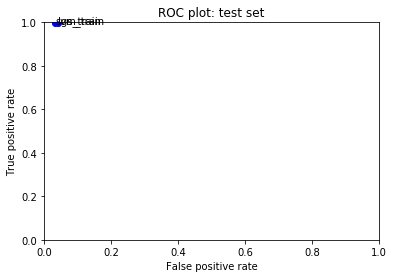

In [14]:
fits = [svm_performance_train, lgs_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# False Positives

In [12]:
print("Examples of false positives:")

import random, time
lgs_predictions = lgs.predict(X_train)

for i in range(0, len(lgs_predictions)):  #when uploading to github, make the length shorter than the entire list
    if (lgs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 10% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

#It may be that its using all caps and profuse use of punctuation is being learned as toxic
#i would like to re-iterate that some of the trained data is mis-labelled or bias!

Examples of false positives:
306
It's 3 rr's to be a war, not two.
* * * * * * * * * 
477
Images are a commonplace on Wikipedia user pages.  Please don't single me out. /
* * * * * * * * * 
584
"
That's the method to my madness. ) ( · talk)  · @927  ·  "
* * * * * * * * * 
933
Rjanag's profile reveals that he is likely connected with the East Turks.
* * * * * * * * * 
1012
POV on God entry 

Thank you for pointing out as such; I'm admittedly late to the conversation, and was hesitant to make the reversion. There are too many people who want to push their own lack of religion on those of us who are Christian or otherwise spiritually inclined.
* * * * * * * * * 
1499
I am IMPROVING the Johnny Test articles. These lessons are unoriginal research, and I will prove it to you.
* * * * * * * * * 
2296
You review it and maybe you will get a clue. I think you are vindictive and petty. You might as well stay out of my page.
* * * * * * * * * 
2847
Agree. The article helped me convince my aging f

19843
How the gosh do I add an edit summary?
* * * * * * * * * 
21781
i will not delete articles like you....attitude
* * * * * * * * * 
21986
Your Edits to Conservapedia

 Please do not attack other editors. If you continue, you will be blocked from editing Wikipedia.
* * * * * * * * * 
22012
http://variancemagazine.com/news/4297-sia-has-already-written-recorded-new-album-this-is-acting (info already incorporated into article)
* * * * * * * * * 
22393
"
The clue is in the word ""blind"".  "
* * * * * * * * * 
22919
These games are so childish
* * * * * * * * * 
23246
"As for the stuttering, slobbering, simp, Oshwah, and the manner in which I speak to Wiki ""censors"", I'll speak to them in ANY way I see fit.

"
* * * * * * * * * 
23757
I thoroughly envy your keyboard. I don't have that style of bracket on this thing.
* * * * * * * * * 
23865
You cant do that.  You didn't even warn me.
* * * * * * * * * 
23878
"
 ""You heard""? Did a little bird tell you?"
* * * * * * * * * 
24528
jail

39328
your insults here on Wikipedia
* * * * * * * * * 
39376
"Things you should know about Wikipedia
 There's always people who are going to take an overactive interest in your talk page and change it to fit what they want it to say...these people have no life.
 Some administrators will lecture you as if you're their own kid...ignore them...that's what I do.
 Saying somebody has a ""hard on"" for your talk page can get you blocked.  But when other people come to your defense in the situation...you really only end up being blocked for 15 minutes.

"
* * * * * * * * * 
39424
Zoe had to go, and that is not a personal attack, but fact. Her reprehensible conduct was antithetical to free speech and undermined the very purpose of this site: the democratization of public information. 

You must understand that the concentration of power into the hands of a few administrators over an organization originally dedicated to open discourse and conversation is a bad thing. Please, tell me you unders

60107
The comments to the Rat trap article
* * * * * * * * * 
60376
Health 

He was really fat. No shocker he died.69.243.42.251
* * * * * * * * * 
61299
BLOCK 

I want a personal explanation. This is really really uncalled for.
* * * * * * * * * 
61377
I know what you mean. You definitely wrong and certainly retarded, but I know what you're trying to say.
* * * * * * * * * 
61653
"

 US-centric 

The layout of this article seems to be somewhat US-centric, with one section on ""other countries"" and everything else about spelling bees in the US.  Simply cramming all the US stuff into one section on the country list seems impractical  perhaps the large amount of US-specific stuff should be split off into a separate article on spelling bees in the US, with just a small section in the country list here that links to there?   "
* * * * * * * * * 
61725
Chillax ladies. 94.14.142.147
* * * * * * * * * 
62126
"

I think yellow armbands were ""fest for all women"" in 2007. FFAW were the people

73439
Pity you didn't take a break sooner.kerry
* * * * * * * * * 
73928
LOL!  You whine like a child.  Can't take criticism, so you whine to ANI.  You DO realize IP addresses are easy to come by, and your silly bans are worthless, right?
* * * * * * * * * 
74367
are you okay or not 
Do you not know about battle of Sirhind,battle of sarsa etc. See fateh burj it commemorates the victory of Sikhs over sirhind and defeat of Mughal army .why you are editing inappropriate information  ? Are you a communal person you not even know history and you just keep editing false information. Check the sources then you will realize your mistakes
* * * * * * * * * 
74605
u mad bro? 186.86.130.176
* * * * * * * * * 
74801
"
 See the AN/I thread.  Let's keep this discussion in one place. BLACKKITE "
* * * * * * * * * 
74867
condition unlike what he did).
* * * * * * * * * 
74885
and I was angry at it.
* * * * * * * * * 
75051
"   
MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU

85606
Gallery
I've removed a picture from the gallery of a woman using a squat toilet. I didn't see what was encyclopedic about a woman hamming for the camera with her pants and underpants around her knees.
* * * * * * * * * 
85822
"The U.S. Department of Energy lists the continental climate as extending ""from Maryland to Maine,"" and shows a map where the humid subtropical climate clearly ends in Virginia 

"
* * * * * * * * * 
85891
"

Firstly, I have to point out that academic presses have never stopped rolling regarding Northern Ireland and Irish/UK politics. As I say from time to time, printing presses by and large print round the clock, esp 'academic' ones. If you can find them, you will have a pool of scores of thousands of sources on the subject, saying pretty-much whatever you want them to.

Secondly, to give quotes that follow the sovereign-only interpretation of 'country' is simply misleading people. Not everyone follows that strict meaning of the term. By the standards of 

104344
Hybrid Guitar
I thought the correct name was a Hybrid Guitar. Because its electric and acoustic.
* * * * * * * * * 
106650
Will you ever reply to my post on your wall?
* * * * * * * * * 
106685
Hello. Is your name now or has it ever been Linda Mack? Are you living in Alberta, Canada under the name of Sarah McEwan? Have ypu even been employed by a government intelligence agency? 

Just wondering.

Kisses! )
* * * * * * * * * 
107989
Rubbish. You can't just make up your own criteria about what I supposedly agree with.
* * * * * * * * * 
108197
"== Block ==

Harassment of T/C 

"
* * * * * * * * * 
109152
no 

either way just go bother someone else
* * * * * * * * * 
109338
}}

 Editor's review 

{{Editor review|Mlpearc (2)|him|his
* * * * * * * * * 
110952
Unsolicited Advice 

Hi Pigsonthewing,

As someone who has been silently observing your behaviour over the past few months on Wikipedia, I am worried by what I perceive to be a downward spiral of petty fighting, vindictiveness, 

125335
Dream By:
 MY DREAM 2 GO HERE!!!!!!!!!!Where's Looney Tunes?
* * * * * * * * * 
125444
I am proud to be a homosexual.  Gay pride 2008!
* * * * * * * * * 
126983
"

Boy was that difficult. ¦   "
* * * * * * * * * 


# Look at performance on the test set

In [17]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2615, 'TN': 25807, 'FP': 2828, 'FN': 665, 'Accuracy': 0.8905530314898951, 'Precision': 0.48043358442035644, 'Recall': 0.7972560975609756, 'desc': 'svm_test'}


In [18]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2659, 'TN': 25601, 'FP': 3034, 'FN': 621, 'Accuracy': 0.8854770484098387, 'Precision': 0.46706481644124365, 'Recall': 0.8106707317073171, 'desc': 'lgs_test'}


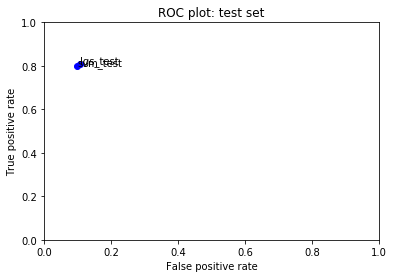

In [19]:
#PLOT

fits = [svm_performance_test, lgs_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [20]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=23, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 1048576)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6      

In [21]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = lgs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

#I had a prediction mean that was .25 before, not sure what changed the result!

0.29042072549685305


In [22]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [23]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [24]:
my_submission.shape

(153164, 2)

In [25]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission2_zina.csv', index=False)